## Introduction
In this notebook, we aim to predict how a brand will rank on the interbrand ranking based on its past ranking, frequency, and word embedding.

The following files are needed to run the codes:

1. the word embedding model file: `L10T50G100A1ngV_iter1.p` (sent via google drive because it is too large for github)
2. the word to id json: `w2id_glove_corpora_minc_100.json` (on github)
3. the interbrand ranking by year json: `interbrand_brand2rankvalue.json` (on github)

In [1]:
# import packages
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np 
import scipy as sp
import scipy.spatial
import scipy.linalg
import json
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from datetime import datetime
from time import time
import pickle
import sys
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, plot_roc_curve, precision_recall_fscore_support

In [2]:
## this is the sample code for using the word embedding model
# model file path
# modify according to your setup
np.random.seed(111)

file_dir = '/Users/vincent/GoogleDriveSync/NTUCourse/BerkeleyCourse/Ming Hsu Lab/various_embedding/pierre2/stereotyping_word2vec_nodata/scraping/nytimes_2011/'
dw2v_filepath = file_dir + 'L10T50G100A1ngV_iter4.p' 
w2id_path = file_dir + 'w2id_glove_corpora_1996-2019_minc_100.json'

# define dynamic word vec class 
class DynamicWordVec():
    def __init__(self, dw2v_filepath, w2id_path):
        with open(dw2v_filepath, 'rb') as f:
            self.wordvec_matrix = pickle.load(f)
            self.num_periods = len(self.wordvec_matrix)

        with open(w2id_path) as f:
            self.w2id = json.load(f)
    
    def get_vec(self, w, yr):
        return self.wordvec_matrix[yr][self.w2id[w], :]

    def sim_by_vec(self, v1, v2, sim_type='cosim'):
        if sim_type == 'inner':
            return np.inner(v1, v2)
        elif sim_type == 'cosim':
            return 1 - sp.spatial.distance.cosine(v1, v2)
        else:
            raise Exception('sim_type should be either "inner" or "cosim"')
    
    def sim_by_word_year(self, w1, y1, w2, y2, sim_type='cosim'):
        v1 = self.wordvec_matrix[y1][self.w2id[w1], :]
        v2 = self.wordvec_matrix[y2][self.w2id[w2], :]
        return self.sim_by_vec(v1, v2, sim_type=sim_type)
    
    def is_in_vocab(self, w):
        return w in self.w2id
    
    def most_similar_words_in_year(self, w1, y1, topn, y2, include_self, sim_type='cosim'):
        temp_dict = {}
        for word in self.w2id:
            cont = True
            if not include_self:
                if word == w1:
                    cont = False
            if cont:
                temp_dict[word] = self.sim_by_word_year(w1, y1, word, y2)
        return sorted(temp_dict.items(), key=lambda x: x[1], reverse=True)[:topn]

## Create dataset for wordvec_t

In [3]:
## Create dataset with pca, first 5 years
# target = rank_t+{tpk} / isonlist_t+{tpk}
'''
tpk = 5

print('read files')
dw2v = DynamicWordVec('./L10T50G100A1ngV_iter4_PCA5.p', w2id_path)
#dw2v = DynamicWordVec(dw2v_filepath, w2id_path)

with open('./interbrand_brand2freq.json') as f:
    brand2year2freq = json.load(f)

with open('./interbrand_brand2rankvalue.json') as f:
    brand2year2rankvalue = json.load(f)

with open('./glove_corpora_totalwordcount.json') as f:
    year2count = json.load(f)

brands = sorted(list(brand2year2freq))
brands = [b for b in brands if dw2v.is_in_vocab(b)]

Ts = range(2001, 2020-tpk)
corpurs_start_t = 1996
rank_if_not_list = 101
n_feature = 43

dataset = []
header = ['brand_year', 'brand', 'year'] + ['wordvec_{}{}'.format(i, j) for i in range(1, 6) for j in range(1, 6)] + \
    ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t'] + \
    ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t'] + \
    ['rank_t', 'rank_t+{}'.format(tpk), 'isonlist_t', 'isonlist_t+{}'.format(tpk), 'delta_rank']
print(len(header))
assert(len(header)==n_feature)
for brand in brands:
    for t in Ts:
        #print(brand, t)
        #wordvec = dw2v.get_vec(brand, t-corpurs_start_t).tolist() # dim-50
        wordvec = []
        for s in range(t-4, t+1):
            wordvec.extend(dw2v.get_vec(brand, t-corpurs_start_t).tolist()) # 5*5=25

        freq_tm4_to_t = [brand2year2freq[brand][str(s)] for s in range(t-4, t+1)]
        totalwordcount_tm4_to_t = [year2count[str(s)] for s in range(t-4, t+1)]
        ratiopermille_tm4_to_t = [freq*1000 / count for freq, count in zip(freq_tm4_to_t, totalwordcount_tm4_to_t)]

        rank_t = brand2year2rankvalue[brand].get(str(t), (rank_if_not_list,))[0] # if not on the list, rank=101
        rank_tpk = brand2year2rankvalue[brand].get(str(t+tpk), (rank_if_not_list,))[0]

        ison_t = rank_t < rank_if_not_list
        ison_tpk = rank_tpk < rank_if_not_list

        brandyear = '{}-{}'.format(brand, t)

        current_row = [brandyear, brand, t] + wordvec + freq_tm4_to_t + ratiopermille_tm4_to_t + [rank_t, rank_tpk, ison_t, ison_tpk, rank_tpk-rank_t]
        current_row = [str(c) for c in current_row]
        assert(len(current_row)==n_feature)
        dataset.append(current_row)


dataset = [','.join(row)+'\n' for row in dataset]
dataset = [','.join(header)+'\n'] + dataset
with open('interbrand_dataset_tp{}_pc5.csv'.format(tpk), 'w') as f:
    for row in dataset:
        f.write(row)
print('done')
'''

"\ntpk = 5\n\nprint('read files')\ndw2v = DynamicWordVec('./L10T50G100A1ngV_iter4_PCA5.p', w2id_path)\n#dw2v = DynamicWordVec(dw2v_filepath, w2id_path)\n\nwith open('./interbrand_brand2freq.json') as f:\n    brand2year2freq = json.load(f)\n\nwith open('./interbrand_brand2rankvalue.json') as f:\n    brand2year2rankvalue = json.load(f)\n\nwith open('./glove_corpora_totalwordcount.json') as f:\n    year2count = json.load(f)\n\nbrands = sorted(list(brand2year2freq))\nbrands = [b for b in brands if dw2v.is_in_vocab(b)]\n\nTs = range(2001, 2020-tpk)\ncorpurs_start_t = 1996\nrank_if_not_list = 101\nn_feature = 43\n\ndataset = []\nheader = ['brand_year', 'brand', 'year'] + ['wordvec_{}{}'.format(i, j) for i in range(1, 6) for j in range(1, 6)] +     ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t'] +     ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t'] +     ['rank_t', 'rank_t+{}'.format(tpk), 'isonlist_t', 'isonlist_t+{}'.format(

In [4]:
## Create dataset
# target = rank_t+{tpk} / isonlist_t+{tpk}
'''
tpk = 1

print('read files')
#dw2v = DynamicWordVec('./L10T50G100A1ngV_iter4_PCA5.p', w2id_path)
#dw2v = DynamicWordVec(dw2v_filepath, w2id_path)

with open('./interbrand_brand2freq.json') as f:
    brand2year2freq = json.load(f)

with open('./interbrand_brand2rankvalue.json') as f:
    brand2year2rankvalue = json.load(f)

with open('./glove_corpora_totalwordcount.json') as f:
    year2count = json.load(f)

brands = sorted(list(brand2year2freq))
brands = [b for b in brands if dw2v.is_in_vocab(b)]

Ts = range(2001, 2020-tpk)
corpurs_start_t = 1996
rank_if_not_list = 101
n_feature = 68

dataset = []
header = ['brand_year', 'brand', 'year'] + ['wordvec_{}'.format(i) for i in range(1, 51)] + \
    ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t'] + \
    ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t'] + \
    ['rank_t', 'rank_t+{}'.format(tpk), 'isonlist_t', 'isonlist_t+{}'.format(tpk), 'delta_rank']
print(len(header))
assert(len(header)==n_feature)
for brand in brands:
    for t in Ts:
        #print(brand, t)
        wordvec = dw2v.get_vec(brand, t-corpurs_start_t).tolist() # dim-50
        freq_tm4_to_t = [brand2year2freq[brand][str(s)] for s in range(t-4, t+1)]
        totalwordcount_tm4_to_t = [year2count[str(s)] for s in range(t-4, t+1)]
        ratiopermille_tm4_to_t = [freq*1000 / count for freq, count in zip(freq_tm4_to_t, totalwordcount_tm4_to_t)]

        rank_t = brand2year2rankvalue[brand].get(str(t), (rank_if_not_list,))[0] # if not on the list, rank=101
        rank_tpk = brand2year2rankvalue[brand].get(str(t+tpk), (rank_if_not_list,))[0]

        ison_t = rank_t < rank_if_not_list
        ison_tpk = rank_tpk < rank_if_not_list

        brandyear = '{}-{}'.format(brand, t)

        current_row = [brandyear, brand, t] + wordvec + freq_tm4_to_t + ratiopermille_tm4_to_t + [rank_t, rank_tpk, ison_t, ison_tpk, rank_tpk-rank_t]
        current_row = [str(c) for c in current_row]
        assert(len(current_row)==n_feature)
        dataset.append(current_row)


dataset = [','.join(row)+'\n' for row in dataset]
dataset = [','.join(header)+'\n'] + dataset
with open('interbrand_dataset_tp{}.csv'.format(tpk), 'w') as f:
    for row in dataset:
        f.write(row)
print('done')
'''

"\ntpk = 1\n\nprint('read files')\n#dw2v = DynamicWordVec('./L10T50G100A1ngV_iter4_PCA5.p', w2id_path)\n#dw2v = DynamicWordVec(dw2v_filepath, w2id_path)\n\nwith open('./interbrand_brand2freq.json') as f:\n    brand2year2freq = json.load(f)\n\nwith open('./interbrand_brand2rankvalue.json') as f:\n    brand2year2rankvalue = json.load(f)\n\nwith open('./glove_corpora_totalwordcount.json') as f:\n    year2count = json.load(f)\n\nbrands = sorted(list(brand2year2freq))\nbrands = [b for b in brands if dw2v.is_in_vocab(b)]\n\nTs = range(2001, 2020-tpk)\ncorpurs_start_t = 1996\nrank_if_not_list = 101\nn_feature = 68\n\ndataset = []\nheader = ['brand_year', 'brand', 'year'] + ['wordvec_{}'.format(i) for i in range(1, 51)] +     ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t'] +     ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t'] +     ['rank_t', 'rank_t+{}'.format(tpk), 'isonlist_t', 'isonlist_t+{}'.format(tpk), 'delta_rank']\npri

In [5]:
'''
# train/valid/test split
tpk = 5
df = pd.read_csv('interbrand_dataset_tp{}_pc5.csv'.format(tpk))

# consider only brands with 1000+ freq
#brand1000p = [b for b in brands if any([brand2year2freq[b][str(y)]>500 for y in range(2001, 2019)])]
#df = df.loc[df['brand'].isin(brand1000p)]

n_data = len(df)
n_train = int(n_data*0.7)
n_valid = int(n_data*0.2)
n_test = n_data - n_train - n_valid
assert(n_train + n_valid + n_test == n_data)

print(n_train, n_valid, n_test, n_data)

group_labels = np.repeat(['train', 'valid', 'test'], [n_train, n_valid, n_test])
np.random.seed(200)
randomized_labels = np.random.choice(group_labels, n_data, replace=False)
df['group'] = randomized_labels

df_train = df[df['group']=='train']
df_valid = df[df['group']=='valid']
df_test = df[df['group']=='test']

df_train = df_train.drop(columns=['group'])
df_valid = df_valid.drop(columns=['group'])
df_test = df_test.drop(columns=['group'])

df_valid_negt = df_valid.loc[df_valid['isonlist_t'] == False]
df_valid_post = df_valid.loc[df_valid['isonlist_t'] == True]
print(len(df_valid_negt))
print(len(df_valid_post))

df_train.to_csv('interbrand_dataset_tp{}_pc5_train.csv'.format(tpk))
df_valid.to_csv('interbrand_dataset_tp{}_pc5_valid.csv'.format(tpk))
df_test.to_csv('interbrand_dataset_tp{}_pc5_test.csv'.format(tpk))
'''

"\n# train/valid/test split\ntpk = 5\ndf = pd.read_csv('interbrand_dataset_tp{}_pc5.csv'.format(tpk))\n\n# consider only brands with 1000+ freq\n#brand1000p = [b for b in brands if any([brand2year2freq[b][str(y)]>500 for y in range(2001, 2019)])]\n#df = df.loc[df['brand'].isin(brand1000p)]\n\nn_data = len(df)\nn_train = int(n_data*0.7)\nn_valid = int(n_data*0.2)\nn_test = n_data - n_train - n_valid\nassert(n_train + n_valid + n_test == n_data)\n\nprint(n_train, n_valid, n_test, n_data)\n\ngroup_labels = np.repeat(['train', 'valid', 'test'], [n_train, n_valid, n_test])\nnp.random.seed(200)\nrandomized_labels = np.random.choice(group_labels, n_data, replace=False)\ndf['group'] = randomized_labels\n\ndf_train = df[df['group']=='train']\ndf_valid = df[df['group']=='valid']\ndf_test = df[df['group']=='test']\n\ndf_train = df_train.drop(columns=['group'])\ndf_valid = df_valid.drop(columns=['group'])\ndf_test = df_test.drop(columns=['group'])\n\ndf_valid_negt = df_valid.loc[df_valid['isonlist

## Create Dataset for delta_wordvec

In [6]:
'''
tpk = 1

print('read files')
dw2v = DynamicWordVec(dw2v_filepath, w2id_path)

with open('./interbrand_brand2freq.json') as f:
    brand2year2freq = json.load(f)

with open('./interbrand_brand2rankvalue.json') as f:
    brand2year2rankvalue = json.load(f)

with open('./glove_corpora_totalwordcount.json') as f:
    year2count = json.load(f)

brands = sorted(list(brand2year2freq))
brands = [b for b in brands if dw2v.is_in_vocab(b)]

# start with 2002 since we need rank_t-1
Ts = range(2002, 2020-tpk)
corpurs_start_t = 1996
rank_if_not_list = 101
n_feature = 69

dataset = []
header = ['brand_year', 'brand', 'year'] + ['delta_wordvec_{}'.format(i) for i in range(1, 51)] + \
    ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t'] + \
    ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t'] + \
    ['rank_t-1', 'rank_t', 'rank_t+{}'.format(tpk), 'isonlist_t', 'isonlist_t+{}'.format(tpk), 'delta_rank']
#print(header)
print(len(header))
assert(len(header)==n_feature)
for brand in brands:
    for t in Ts:
        #print(brand, t)
        wordvec_t = dw2v.get_vec(brand, t-corpurs_start_t) # dim-50
        wordvec_tm1 = dw2v.get_vec(brand, t-1-corpurs_start_t)
        delta_wordvec = (wordvec_t - wordvec_tm1).tolist()

        freq_tm4_to_t = [brand2year2freq[brand][str(s)] for s in range(t-4, t+1)]
        totalwordcount_tm4_to_t = [year2count[str(s)] for s in range(t-4, t+1)]
        ratiopermille_tm4_to_t = [freq*1000 / count for freq, count in zip(freq_tm4_to_t, totalwordcount_tm4_to_t)]

        rank_tm1 = brand2year2rankvalue[brand].get(str(t-1), (rank_if_not_list,))[0]
        rank_t = brand2year2rankvalue[brand].get(str(t), (rank_if_not_list,))[0] # if not on the list, rank=101
        rank_tpk = brand2year2rankvalue[brand].get(str(t+tpk), (rank_if_not_list,))[0]

        ison_t = rank_t < rank_if_not_list
        ison_tpk = rank_tpk < rank_if_not_list

        brandyear = '{}-{}'.format(brand, t)

        current_row = [brandyear, brand, t] + delta_wordvec + freq_tm4_to_t + ratiopermille_tm4_to_t + [rank_tm1, rank_t, rank_tpk, ison_t, ison_tpk, rank_tpk-rank_t]
        current_row = [str(c) for c in current_row]
        assert(len(current_row)==n_feature)
        dataset.append(current_row)


dataset = [','.join(row)+'\n' for row in dataset]
dataset = [','.join(header)+'\n'] + dataset
with open('interbrand_dataset_tp{}_deltavec.csv'.format(tpk), 'w') as f:
    for row in dataset:
        f.write(row)
print('done')
'''

"\ntpk = 1\n\nprint('read files')\ndw2v = DynamicWordVec(dw2v_filepath, w2id_path)\n\nwith open('./interbrand_brand2freq.json') as f:\n    brand2year2freq = json.load(f)\n\nwith open('./interbrand_brand2rankvalue.json') as f:\n    brand2year2rankvalue = json.load(f)\n\nwith open('./glove_corpora_totalwordcount.json') as f:\n    year2count = json.load(f)\n\nbrands = sorted(list(brand2year2freq))\nbrands = [b for b in brands if dw2v.is_in_vocab(b)]\n\n# start with 2002 since we need rank_t-1\nTs = range(2002, 2020-tpk)\ncorpurs_start_t = 1996\nrank_if_not_list = 101\nn_feature = 69\n\ndataset = []\nheader = ['brand_year', 'brand', 'year'] + ['delta_wordvec_{}'.format(i) for i in range(1, 51)] +     ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t'] +     ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t'] +     ['rank_t-1', 'rank_t', 'rank_t+{}'.format(tpk), 'isonlist_t', 'isonlist_t+{}'.format(tpk), 'delta_rank']\n#print(header

In [7]:
'''
df = pd.read_csv('interbrand_dataset_tp{}_deltavec.csv'.format(tpk))

# consider only brands with 1000+ freq
#brand1000p = [b for b in brands if any([brand2year2freq[b][str(y)]>500 for y in range(2001, 2019)])]
#df = df.loc[df['brand'].isin(brand1000p)]

n_data = len(df)
n_train = int(n_data*0.7)
n_valid = int(n_data*0.2)
n_test = n_data - n_train - n_valid
assert(n_train + n_valid + n_test == n_data)

print(n_train, n_valid, n_test, n_data)

group_labels = np.repeat(['train', 'valid', 'test'], [n_train, n_valid, n_test])
np.random.seed(200)
randomized_labels = np.random.choice(group_labels, n_data, replace=False)
df['group'] = randomized_labels

df_train = df[df['group']=='train']
df_valid = df[df['group']=='valid']
df_test = df[df['group']=='test']

df_train = df_train.drop(columns=['group'])
df_valid = df_valid.drop(columns=['group'])
df_test = df_test.drop(columns=['group'])

df_valid_negt = df_valid.loc[df_valid['isonlist_t'] == False]
df_valid_post = df_valid.loc[df_valid['isonlist_t'] == True]
print(len(df_valid_negt))
print(len(df_valid_post))

df_train.to_csv('interbrand_dataset_tp{}_deltavec_train.csv'.format(tpk))
df_valid.to_csv('interbrand_dataset_tp{}_deltavec_valid.csv'.format(tpk))
df_test.to_csv('interbrand_dataset_tp{}_deltavec_test.csv'.format(tpk))
'''

"\ndf = pd.read_csv('interbrand_dataset_tp{}_deltavec.csv'.format(tpk))\n\n# consider only brands with 1000+ freq\n#brand1000p = [b for b in brands if any([brand2year2freq[b][str(y)]>500 for y in range(2001, 2019)])]\n#df = df.loc[df['brand'].isin(brand1000p)]\n\nn_data = len(df)\nn_train = int(n_data*0.7)\nn_valid = int(n_data*0.2)\nn_test = n_data - n_train - n_valid\nassert(n_train + n_valid + n_test == n_data)\n\nprint(n_train, n_valid, n_test, n_data)\n\ngroup_labels = np.repeat(['train', 'valid', 'test'], [n_train, n_valid, n_test])\nnp.random.seed(200)\nrandomized_labels = np.random.choice(group_labels, n_data, replace=False)\ndf['group'] = randomized_labels\n\ndf_train = df[df['group']=='train']\ndf_valid = df[df['group']=='valid']\ndf_test = df[df['group']=='test']\n\ndf_train = df_train.drop(columns=['group'])\ndf_valid = df_valid.drop(columns=['group'])\ndf_test = df_test.drop(columns=['group'])\n\ndf_valid_negt = df_valid.loc[df_valid['isonlist_t'] == False]\ndf_valid_post 

In [8]:
tpk = 5
print('Current model: ', tpk)
df_train = pd.read_csv('interbrand_dataset_tp{}_pc5_train.csv'.format(tpk))
df_valid = pd.read_csv('interbrand_dataset_tp{}_pc5_valid.csv'.format(tpk))

Current model:  5


## Predict rank_t+{tpk}

In [9]:
feature_list_e = ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t']

features_e = df_train[feature_list_e].to_numpy()
target_e = df_train['rank_t+{}'.format(tpk)].to_numpy()

valid_features_e = df_valid[feature_list_e].to_numpy()
valid_target = df_valid['rank_t+{}'.format(tpk)].to_numpy()

#lr = LinearRegression(n_jobs=-1).fit(features_e, target_e)
rf = RandomForestRegressor(n_jobs=-1).fit(features_e, target_e)
#hat_valid_target_e = lr.predict(valid_features_e)
hat_valid_target_e = rf.predict(valid_features_e)

mae_e = mean_absolute_error(valid_target, hat_valid_target_e)

print('mae_e: ', mae_e)

mae_e:  28.95828341640971


In [10]:
feature_list_f = ['rank_t']

features_f = df_train[feature_list_f].to_numpy()
target_f = df_train['rank_t+{}'.format(tpk)].to_numpy()

valid_features_f = df_valid[feature_list_f].to_numpy()
valid_target = df_valid['rank_t+{}'.format(tpk)].to_numpy()

#lr = LinearRegression(n_jobs=-1).fit(features_f, target_f)
#hat_valid_target_f = lr.predict(valid_features_f)

rf = RandomForestRegressor(n_jobs=-1).fit(features_f, target_f)
hat_valid_target_f = rf.predict(valid_features_f)

mae_f = mean_absolute_error(valid_target, hat_valid_target_f)

print('mae_f: ', mae_f)

mae_f:  14.147512117898405


In [11]:
#feature_list_g = ['wordvec_{}'.format(i) for i in range(1, 51)]
feature_list_g = ['wordvec_{}{}'.format(i, j) for i in range(1, 6) for j in range(1, 6)]

features_g = df_train[feature_list_g].to_numpy()
target_g = df_train['rank_t+{}'.format(tpk)].to_numpy()

valid_features_g = df_valid[feature_list_g].to_numpy()
#valid_target_g = df_valid['rank_t+{}'.format(tpk)].to_numpy()

#lr = LinearRegression(n_jobs=-1).fit(features_g, target_g)
#hat_valid_target_g = lr.predict(valid_features_g)

rf = RandomForestRegressor(n_jobs=-1).fit(features_g, target_g)
hat_valid_target_g = rf.predict(valid_features_g)

mae_g = mean_absolute_error(valid_target, hat_valid_target_g)

print('mae_g: ', mae_g)

mae_g:  23.82846522781775


In [12]:
feature_list_hh = ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t']

features_hh = df_train[feature_list_hh].to_numpy()
target_hh = df_train['rank_t+{}'.format(tpk)].to_numpy()

valid_features_hh = df_valid[feature_list_hh].to_numpy()
#valid_target_hh = df_valid['rank_t+{}'.format(tpk)].to_numpy()

#lr = LinearRegression(n_jobs=-1).fit(features_hh, target_hh)
#hat_valid_target_hh = lr.predict(valid_features_hh)
rf = RandomForestRegressor(n_jobs=-1).fit(features_hh, target_hh)
hat_valid_target_hh = rf.predict(valid_features_hh)

mae_hh = mean_absolute_error(valid_target, hat_valid_target_hh)

print('mae_hh: ', mae_hh)

mae_hh:  28.984042094512642


Text(0.5, 1.0, 'IV: relative frequency [t-4 ~ t] (MAE=28.98)')

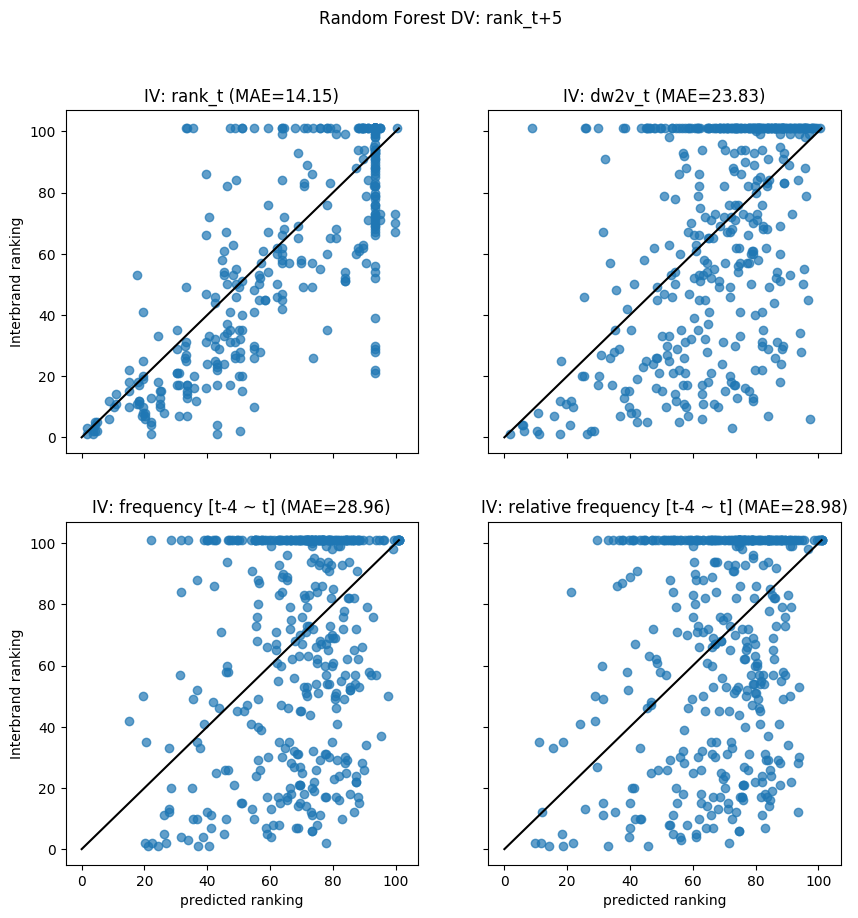

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 10), dpi=100)
fig.suptitle('Random Forest DV: rank_t+{}'.format(tpk))
# rank_t
axes[0, 0].scatter(hat_valid_target_f, valid_target, alpha=0.7)
axes[0, 0].plot([0, 101], [0, 101], color='black')
axes[0, 0].set_ylabel('Interbrand ranking')
axes[0, 0].set_title('IV: rank_t (MAE={:.2f})'.format(mae_f))
# dw2v
axes[0, 1].scatter(hat_valid_target_g, valid_target, alpha=0.7)
axes[0, 1].plot([0, 101], [0, 101], color='black')
axes[0, 1].set_title('IV: dw2v_t (MAE={:.2f})'.format(mae_g))
# freq
axes[1, 0].scatter(hat_valid_target_e, valid_target, alpha=0.7)
axes[1, 0].plot([0, 101], [0, 101], color='black')
axes[1, 0].set_ylabel('Interbrand ranking')
axes[1, 0].set_xlabel('predicted ranking')
axes[1, 0].set_title('IV: frequency [t-4 ~ t] (MAE={:.2f})'.format(mae_e))
# ratiomille
axes[1, 1].scatter(hat_valid_target_hh, valid_target, alpha=0.7)
axes[1, 1].plot([0, 101], [0, 101], color='black')
axes[1, 1].set_xlabel('predicted ranking')
axes[1, 1].set_title('IV: relative frequency [t-4 ~ t] (MAE={:.2f})'.format(mae_hh))

In [14]:
fig.savefig('rank_tp{}_lr_pc5.png'.format(tpk))

## Predict delta_rank

In [ ]:
feature_list_ii = ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t']

features_ii = df_train[feature_list_ii].to_numpy()
target_ii = df_train['delta_rank'].to_numpy()

valid_features_ii = df_valid[feature_list_ii].to_numpy()
valid_target = df_valid['delta_rank'].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_ii, target_ii)
hat_valid_target_ii = lr.predict(valid_features_ii)

mae_ii = mean_absolute_error(valid_target, hat_valid_target_ii)

print('mae_ii: ', mae_ii)

In [ ]:
feature_list_jj = ['rank_t']

features_jj = df_train[feature_list_jj].to_numpy()
target_jj = df_train['delta_rank'].to_numpy()

valid_features_jj = df_valid[feature_list_jj].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_jj, target_jj)
hat_valid_target_jj = lr.predict(valid_features_jj)

mae_jj = mean_absolute_error(valid_target, hat_valid_target_jj)

print('mae_jj: ', mae_jj)

In [ ]:
feature_list_kk = ['wordvec_{}'.format(i) for i in range(1, 51)]

features_kk = df_train[feature_list_kk].to_numpy()
target_kk = df_train['delta_rank'].to_numpy()

valid_features_kk = df_valid[feature_list_kk].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_kk, target_kk)
hat_valid_target_kk = lr.predict(valid_features_kk)

mae_kk = mean_absolute_error(valid_target, hat_valid_target_kk)

print('mae_kk: ', mae_kk)

In [ ]:
feature_list_ll = ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t']

features_ll = df_train[feature_list_ll].to_numpy()
target_ll = df_train['delta_rank'].to_numpy()

valid_features_ll = df_valid[feature_list_ll].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_ll, target_ll)
hat_valid_target_ll = lr.predict(valid_features_ll)

mae_ll = mean_absolute_error(valid_target, hat_valid_target_ll)

print('mae_ll: ', mae_ll)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 10), dpi=100)
fig.suptitle('DV: delta_rank (rank_t+{}-rank_t)'.format(tpk))
# rank_t
axes[0, 0].scatter(hat_valid_target_jj, valid_target, alpha=0.7)
axes[0, 0].plot([0, 101], [0, 101], color='black')
axes[0, 0].set_ylabel('Interbrand ranking')
axes[0, 0].set_title('IV: rank_t (MAE={:.2f})'.format(mae_jj))
# dw2v
axes[0, 1].scatter(hat_valid_target_kk, valid_target, alpha=0.7)
axes[0, 1].plot([0, 101], [0, 101], color='black')
axes[0, 1].set_title('IV: dw2v_t (MAE={:.2f})'.format(mae_kk))
# freq
axes[1, 0].scatter(hat_valid_target_ii, valid_target, alpha=0.7)
axes[1, 0].plot([0, 101], [0, 101], color='black')
axes[1, 0].set_ylabel('Interbrand ranking')
axes[1, 0].set_xlabel('predicted ranking')
axes[1, 0].set_title('IV: frequency [t-4 ~ t] (MAE={:.2f})'.format(mae_ii))
# ratiomille
axes[1, 1].scatter(hat_valid_target_ll, valid_target, alpha=0.7)
axes[1, 1].plot([0, 101], [0, 101], color='black')
axes[1, 1].set_xlabel('predicted ranking')
axes[1, 1].set_title('IV: relative frequency [t-4 ~ t] (MAE={:.2f})'.format(mae_ll))

fig.savefig('delta_rank_tp{}.png'.format(tpk))

## Predict delta_rank w/ delta_vec

In [ ]:
tpk = 9
print('Current model: ', tpk)
df_train = pd.read_csv('interbrand_dataset_tp{}_deltavec_train.csv'.format(tpk))
df_valid = pd.read_csv('interbrand_dataset_tp{}_deltavec_valid.csv'.format(tpk))

target_list = ['delta_rank']
target = df_train[target_list].to_numpy()
valid_target = df_valid[target_list].to_numpy()
modellabel2results = {}

In [ ]:
model_label = 'freq'

feature_list_mm = ['freq_t-4', 'freq_t-3', 'freq_t-2', 'freq_t-1', 'freq_t']

features_mm = df_train[feature_list_mm].to_numpy()
valid_features_mm = df_valid[feature_list_mm].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_mm, target)
hat_valid_target_mm = lr.predict(valid_features_mm)

mae_mm = mean_absolute_error(valid_target, hat_valid_target_mm)

print('mae_mm: ', mae_mm)

modellabel2results[model_label] = (hat_valid_target_mm, mae_mm)

In [ ]:
model_label = 'rank_t'

feature_list_nn = ['rank_t-1','rank_t']

features_nn = df_train[feature_list_nn].to_numpy()
valid_features_nn = df_valid[feature_list_nn].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_nn, target)
hat_valid_target_nn = lr.predict(valid_features_nn)

mae_nn = mean_absolute_error(valid_target, hat_valid_target_nn)

print('mae_nn: ', mae_nn)

modellabel2results[model_label] = (hat_valid_target_nn, mae_nn)

In [ ]:
model_label = 'delta_wordvec'

feature_list_oo = ['delta_wordvec_{}'.format(i) for i in range(1, 51)]

features_oo = df_train[feature_list_oo].to_numpy()
valid_features_oo = df_valid[feature_list_oo].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_oo, target)
hat_valid_target_oo = lr.predict(valid_features_oo)

mae_oo = mean_absolute_error(valid_target, hat_valid_target_oo)

print('mae_oo: ', mae_oo)

modellabel2results[model_label] = (hat_valid_target_oo, mae_oo)

In [ ]:
model_label = 'relative_freq'

feature_list_pp = ['ratiopermille_t-4', 'ratiopermille_t-3', 'ratiopermille_t-2', 'ratiopermille_t-1', 'ratiopermille_t']

features_pp = df_train[feature_list_pp].to_numpy()
valid_features_pp = df_valid[feature_list_pp].to_numpy()

lr = LinearRegression(n_jobs=-1).fit(features_pp, target)
hat_valid_target_pp = lr.predict(valid_features_pp)

mae_pp = mean_absolute_error(valid_target, hat_valid_target_pp)

print('mae_pp: ', mae_pp)

modellabel2results[model_label] = (hat_valid_target_pp, mae_pp)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 10), dpi=100)
fig.suptitle('DV: delta_rank (rank_t+{}-rank_t)'.format(tpk))
# rank_t
axes[0, 0].scatter(modellabel2results['rank_t'][0], valid_target, alpha=0.7)
axes[0, 0].plot([0, 101], [0, 101], color='black')
axes[0, 0].set_ylabel('Interbrand ranking')
axes[0, 0].set_title('IV: rank_t-1, rank_t (MAE={:.2f})'.format(modellabel2results['rank_t'][1]))
# dw2v
axes[0, 1].scatter(modellabel2results['delta_wordvec'][0], valid_target, alpha=0.7)
axes[0, 1].plot([0, 101], [0, 101], color='black')
axes[0, 1].set_title('IV: dw2v_t - dw2v_t-1 (MAE={:.2f})'.format(modellabel2results['delta_wordvec'][1]))
# freq
axes[1, 0].scatter(modellabel2results['freq'][0], valid_target, alpha=0.7)
axes[1, 0].plot([0, 101], [0, 101], color='black')
axes[1, 0].set_ylabel('Interbrand ranking')
axes[1, 0].set_xlabel('predicted ranking')
axes[1, 0].set_title('IV: frequency [t-4 ~ t] (MAE={:.2f})'.format(modellabel2results['freq'][1]))
# ratiomille
axes[1, 1].scatter(modellabel2results['relative_freq'][0], valid_target, alpha=0.7)
axes[1, 1].plot([0, 101], [0, 101], color='black')
axes[1, 1].set_xlabel('predicted ranking')
axes[1, 1].set_title('IV: relative frequency [t-4 ~ t] (MAE={:.2f})'.format(modellabel2results['relative_freq'][1]))

fig.savefig('delta_rank_tp{}_deltavec.png'.format(tpk))